In [1]:
%matplotlib inline

In [2]:
import os
dirname = "/Users/aphearin/Dropbox/protoDC2"
sdss_basename = "volume_complete_sdss.hdf5"
umachine_z0_basename = "value_added_umachine_sfr_catalog_1.002310.hdf5"
protoDC2_basename = "value_added_protoDC2_snapnum_487.hdf5"

from astropy.table import Table
sdss = Table.read(os.path.join(dirname, sdss_basename), path='data')
protoDC2_z0 = Table.read(os.path.join(dirname, protoDC2_basename), path='data')

pdc2_cenmask = protoDC2_z0['isCentral'] == 1

from rescale_dc2.load_catalogs import load_closest_available_umachine_catalog
umachine_z0 = load_closest_available_umachine_catalog(0.)
um_cenmask = umachine_z0['upid'] == -1

print(protoDC2_z0.keys())
print("\n")
print(umachine_z0.keys())

['magnitude:SDSS_u:rest', 'magnitude:SDSS_g:rest', 'magnitude:SDSS_r:rest', 'magnitude:SDSS_i:rest', 'magnitude:SDSS_z:rest', 'infallHaloMass', 'hostHaloMass', 'hostIndex', 'isCentral', 'spheroidMassStellar', 'totalMassStellar', 'galaxyID', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'totalStarFormationRate', 'totalStarFormationRate_percentile_fixed_totalMassStellar']


['id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'obs_sm', 'obs_sfr', 'mpeak', 'mvir', 'vmax', 'vmax_at_mpeak', 'upid', 'hostid', 'host_halo_is_in_catalog', 'host_halo_mvir', 'host_halo_vmax', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'obs_ssfr', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz']


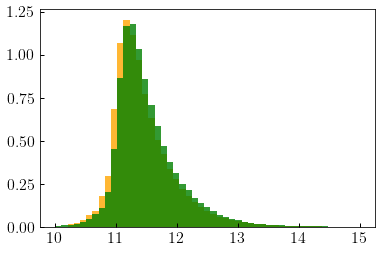

In [3]:
fig, ax = plt.subplots(1, 1)

log_mhost_bins = np.linspace(10, 15, 50)

__=ax.hist(np.log10(protoDC2_z0['hostHaloMass'][pdc2_cenmask]), bins=log_mhost_bins, 
          normed=True, alpha=0.8, color='orange')
__=ax.hist(np.log10(umachine_z0['host_halo_mvir'][um_cenmask]), bins=log_mhost_bins, 
          normed=True, alpha=0.8, color='green')

In [4]:
from galsampler import halo_bin_indices

protoDC2_z0['bin_number'] = halo_bin_indices(
    logmass=(np.log10(protoDC2_z0['hostHaloMass']), log_mhost_bins))
umachine_z0['bin_number'] = halo_bin_indices(
    logmass=(np.log10(umachine_z0['host_halo_mvir']), log_mhost_bins))

from galsampler import source_galaxy_selection_indices

source_galaxies_host_halo_id = umachine_z0['hostid']
source_halos_bin_number = umachine_z0['bin_number'][um_cenmask]
source_halos_halo_id = umachine_z0['id'][um_cenmask]
target_halos_bin_number = protoDC2_z0['bin_number'][pdc2_cenmask]
target_halo_ids = protoDC2_z0['hostIndex'][pdc2_cenmask]
nhalo_min = 25

result = source_galaxy_selection_indices(source_galaxies_host_halo_id,
            source_halos_bin_number, source_halos_halo_id,
            target_halos_bin_number, target_halo_ids, nhalo_min, log_mhost_bins)

selection_indices, target_galaxy_target_halo_ids, target_galaxy_source_halo_ids = result

ngals_target = len(selection_indices)

from astropy.table import Table
dc2 = Table()

dc2['host_halo_id'] = target_galaxy_target_halo_ids
dc2['source_host_halo_id'] = target_galaxy_source_halo_ids

dc2['source_galaxy_id'] = umachine_z0['id'][selection_indices]
dc2['mstar'] = umachine_z0['obs_sm'][selection_indices]
dc2['ssfr'] = umachine_z0['obs_ssfr'][selection_indices]

posvel_keys = ('x', 'y', 'z', 'vx', 'vy', 'vz')
for key in posvel_keys:
    dc2['host_centric_'+key] = umachine_z0['host_centric_'+key][selection_indices]

print(dc2.keys())

['host_halo_id', 'source_host_halo_id', 'source_galaxy_id', 'mstar', 'ssfr', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz']


In [5]:
from halotools.utils import crossmatch 

idxA, idxB = crossmatch(dc2['host_halo_id'], protoDC2_z0['hostIndex'][pdc2_cenmask])

posvel_keys = ('x', 'y', 'z', 'vx', 'vy', 'vz')
for key in posvel_keys:
    dc2['host_'+key] = 0.
    dc2['host_'+key][idxA] = protoDC2_z0[key][idxB]

    dc2[key] = dc2['host_'+key] + dc2['host_centric_'+key]


In [6]:
from halotools.empirical_models import enforce_periodicity_of_box

for key in ('x', 'y', 'z'):
    dc2[key], dc2['v'+key] = enforce_periodicity_of_box(dc2[key], 256., velocity=dc2['v'+key])

In [7]:
from halotools.mock_observables import return_xyz_formatted_array, tpcf

m1, m2, m3, m4 = 9.5, 10, 10.5, 11

dc2_mask1 = dc2['mstar'] > 10**m1
dc2_mask2 = dc2['mstar'] > 10**m2
dc2_mask3 = dc2['mstar'] > 10**m3
dc2_mask4 = dc2['mstar'] > 10**m4

um_mask1 = umachine_z0['obs_sm'] > 10**m1
um_mask2 = umachine_z0['obs_sm'] > 10**m2
um_mask3 = umachine_z0['obs_sm'] > 10**m3
um_mask4 = umachine_z0['obs_sm'] > 10**m4

dc2_pos1 = return_xyz_formatted_array(dc2['x'], dc2['y'], dc2['z'], mask=dc2_mask1)
dc2_pos2 = return_xyz_formatted_array(dc2['x'], dc2['y'], dc2['z'], mask=dc2_mask2)
dc2_pos3 = return_xyz_formatted_array(dc2['x'], dc2['y'], dc2['z'], mask=dc2_mask3)
dc2_pos4 = return_xyz_formatted_array(dc2['x'], dc2['y'], dc2['z'], mask=dc2_mask4)

um_pos1 = return_xyz_formatted_array(
    umachine_z0['x'], umachine_z0['y'], umachine_z0['z'], mask=um_mask1)
um_pos2 = return_xyz_formatted_array(
    umachine_z0['x'], umachine_z0['y'], umachine_z0['z'], mask=um_mask2)
um_pos3 = return_xyz_formatted_array(
    umachine_z0['x'], umachine_z0['y'], umachine_z0['z'], mask=um_mask3)
um_pos4 = return_xyz_formatted_array(
    umachine_z0['x'], umachine_z0['y'], umachine_z0['z'], mask=um_mask4)



In [10]:
log_rbins = np.linspace(-1, 1.3, 25)
rbins = 10**log_rbins
rmids = 10**(0.5*(log_rbins[:-1] + log_rbins[1:]))

In [8]:
from halotools.mock_observables import tpcf

from time import time 

start = time()

xi_dc2_m1 = tpcf(dc2_pos1, rbins, period=256.)
xi_dc2_m2 = tpcf(dc2_pos2, rbins, period=256.)
xi_dc2_m3 = tpcf(dc2_pos3, rbins, period=256.)
xi_dc2_m4 = tpcf(dc2_pos4, rbins, period=256.)

end = time()
print("runtime = {0:.2f} seconds".format(end-start))

runtime = 33.84 seconds


In [9]:
start = time()

xi_um_m1 = tpcf(um_pos1, rbins, period=250.)
xi_um_m2 = tpcf(um_pos2, rbins, period=250.)
xi_um_m3 = tpcf(um_pos3, rbins, period=250.)
xi_um_m4 = tpcf(um_pos4, rbins, period=250.)

end = time()
print("runtime = {0:.2f} seconds".format(end-start))

runtime = 21.50 seconds


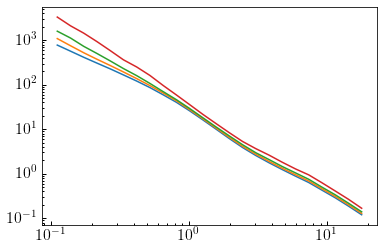

In [13]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.plot(rmids, xi_um_m1, label=r'$M_{\ast} > 10^{9.5}M_{\odot}$')
__=ax.plot(rmids, xi_um_m2, label=r'$M_{\ast} > 10^{10}M_{\odot}$')
__=ax.plot(rmids, xi_um_m3, label=r'$M_{\ast} > 10^{10.5}M_{\odot}$')
__=ax.plot(rmids, xi_um_m4, label=r'$M_{\ast} > 10^{11}M_{\odot}$')

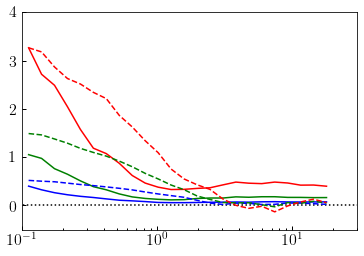

In [30]:
fracdiff_um_m2_by_m1 = (xi_um_m2 - xi_um_m1)/xi_um_m1
fracdiff_um_m3_by_m1 = (xi_um_m3 - xi_um_m1)/xi_um_m1
fracdiff_um_m4_by_m1 = (xi_um_m4 - xi_um_m1)/xi_um_m1

fracdiff_dc2_m2_by_m1 = (xi_dc2_m2 - xi_dc2_m1)/xi_dc2_m1
fracdiff_dc2_m3_by_m1 = (xi_dc2_m3 - xi_dc2_m1)/xi_dc2_m1
fracdiff_dc2_m4_by_m1 = (xi_dc2_m4 - xi_dc2_m1)/xi_dc2_m1

fig, ax = plt.subplots(1, 1)

xscale = ax.set_xscale('log')

xlim = ax.set_xlim(0.1, 30)

__=ax.plot(np.logspace(-3, 3, 100), np.zeros(100), ':', color='k')
__=ax.plot(rmids, fracdiff_um_m2_by_m1, color='blue')
__=ax.plot(rmids, fracdiff_um_m3_by_m1, color='green')
__=ax.plot(rmids, fracdiff_um_m4_by_m1, color='red')

__=ax.plot(rmids, fracdiff_dc2_m2_by_m1, '--', color='blue')
__=ax.plot(rmids, fracdiff_dc2_m3_by_m1, '--', color='green')
__=ax.plot(rmids, fracdiff_dc2_m4_by_m1, '--', color='red')

ylim = ax.set_ylim(-0.5, 4)